In [0]:
import mlflow
import mlflow.spark
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.classification import GBTClassifier 
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col, when

# --- CONFIGURATION ---
CATALOG = "project_fraud_detection"
GOLD_TABLE = f"{CATALOG}.gold_layer.model_features"
MLFLOW_TMP_DIR = f"/Volumes/{CATALOG}/source_data/checkpoints/mlflow_tmp"

def train_gbt_model():
    print("--- 1. Loading Gold Data ---")
    df = spark.table(GOLD_TABLE)
    
    # --- 2. SMART BALANCING ---
    # GBT is very sensitive. We calculate weights but Cap them to prevent overfitting.
    fraud_count = df.filter(col("is_fraud") == 1).count()
    total_count = df.count()
    balancing_ratio = (total_count - fraud_count) / fraud_count
    
    # Cap the weight at 100.0 (Even if ratio is 170, 100 is usually enough for GBT)
    # This prevents the model from "exploding" on outliers
    final_weight = min(balancing_ratio, 100.0)
    
    print(f"Fraud Ratio: {balancing_ratio:.2f}. Using Capped Weight: {final_weight}")
    
    df_weighted = df.withColumn("classWeight", when(col("is_fraud") == 1, final_weight).otherwise(1.0))
    
    train_df, test_df = df_weighted.randomSplit([0.8, 0.2], seed=42)

    # --- 3. PIPELINE DEFINITION ---
    cat_indexer = StringIndexer(inputCol="category", outputCol="category_idx", handleInvalid="keep")
    gender_indexer = StringIndexer(inputCol="gender", outputCol="gender_idx", handleInvalid="keep")
    
    # GBT works best with simple Indexers for high cardinality, but OneHot is safer for "Category"
    encoder = OneHotEncoder(inputCols=["category_idx", "gender_idx"], 
                            outputCols=["category_vec", "gender_vec"])
    
    assembler = VectorAssembler(
        inputCols=[
            "amount", 
            "amt_relative_to_category", # <-- The STAR feature
            "hour_of_day", 
            "day_of_week", 
            "customer_age", 
            "distance_km",              # <-- GBT will learn to ignore this if it's useless
            "category_vec", 
            "gender_vec"
        ],
        outputCol="features"
    )
    
    # --- 4. THE UPGRADE: GBT CLASSIFIER ---
    gbt = GBTClassifier(
        labelCol="is_fraud", 
        featuresCol="features",
        weightCol="classWeight",
        maxIter=100,    # Train 100 trees (High precision)
        maxDepth=5,     # Depth 5 captures complex "Amount vs Category" interactions
        stepSize=0.1,   # Learning rate (Learn slowly to avoid mistakes)
        seed=42
    )

    pipeline = Pipeline(stages=[cat_indexer, gender_indexer, encoder, assembler, gbt])

    # --- 5. TRAIN & EVALUATE ---
    print("--- Training Optimized GBT Model---")
    with mlflow.start_run(run_name="GBT_Fraud_Optimized"):
        model = pipeline.fit(train_df)
        predictions = model.transform(test_df)
        
        # PR AUC is the standard for Fraud
        evaluator = BinaryClassificationEvaluator(labelCol="is_fraud", metricName="areaUnderPR")
        pr_auc = evaluator.evaluate(predictions)
        
        # ROC AUC 
        evaluator_roc = BinaryClassificationEvaluator(labelCol="is_fraud", metricName="areaUnderROC")
        roc_auc = evaluator_roc.evaluate(predictions)
        
        mlflow.log_metric("pr_auc", pr_auc)
        mlflow.log_metric("roc_auc", roc_auc)
        
        mlflow.spark.log_model(model, "fraud_model_gbt", dfs_tmpdir=MLFLOW_TMP_DIR)
        
        print(f"SUCCESS! GBT Trained.")
        print(f"Model Precision-Recall AUC: {pr_auc:.4f}")
        print(f"Model ROC AUC: {roc_auc:.4f}")
        
        # Feature Importance
        # GBT importance is calculated
        print("Feature Importances:", model.stages[-1].featureImportances)
        
    return model, predictions

# --- EXECUTE ---
model, preds = train_gbt_model()

--- 1. Loading Gold Data ---
Fraud Ratio: 171.75. Using Capped Weight: 100.0
--- Training Optimized GBT Model---


2026/01/30 07:02:01 WARNING mlflow.utils.requirements_utils: Found pyspark version (4.0.0+databricks.connect.17.2.2) contains a local version label (+databricks.connect.17.2.2). MLflow logged a pip requirement for this package as 'pyspark==4.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2026/01/30 07:02:06 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /local_disk0/user_tmp_data/spark-4617bf84-ec45-44e2-a9ec-d8/tmpctul_djn/model, flavor: spark). Fall back to return ['pyspark==4.0.0']. Set logging level to DEBUG to see the full traceback. 
2026/01/30 07:02:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


SUCCESS! GBT Trained.
Model Precision-Recall AUC: 0.7750
Model ROC AUC: 0.9953
Feature Importances: (22,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],[0.4689636007768246,0.08488269290810006,0.12040459481273864,0.0018824883531566813,0.06616429764905282,0.0017156406980786015,0.04973675374682304,0.01888696541305559,0.015652231727139747,0.0006488100961518834,0.022991681578598416,0.0022317659124289194,0.002796702654980549,0.018401082527309844,0.019712974003898254,0.014328513567343815,0.04077893679872323,0.000659003065288889,0.0205577224376457,0.009028356934880471,0.019575184337780296])


In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def get_detailed_metrics(predictions):
    print("--- Detailed Model Performance ---")
    
    # Initialize Evaluators
    # Metric options: "accuracy", "weightedPrecision", "weightedRecall", "f1"
    evaluator_acc = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="accuracy")
    evaluator_prec = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="weightedPrecision")
    evaluator_rec = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="weightedRecall")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="f1")

    # Calculate
    acc = evaluator_acc.evaluate(predictions)
    prec = evaluator_prec.evaluate(predictions)
    rec = evaluator_rec.evaluate(predictions)
    f1 = evaluator_f1.evaluate(predictions)

    # Print nicely
    print(f"Accuracy:  {acc:.4f}  (Overall Correctness)")
    print(f"Precision: {prec:.4f}  (Quality of Positive Predictions)")
    print(f"Recall:    {rec:.4f}  (Quantity of Fraud Caught)")
    print(f"F1 Score:  {f1:.4f}   (Balance between Precision & Recall)")

# Execute
get_detailed_metrics(preds)

--- Detailed Model Performance ---
Accuracy:  0.9781  (Overall Correctness)
Precision: 0.9952  (Quality of Positive Predictions)
Recall:    0.9781  (Quantity of Fraud Caught)
F1 Score:  0.9852   (Balance between Precision & Recall)


--- Generating ROC Curve ---
Converting to Pandas for plotting...


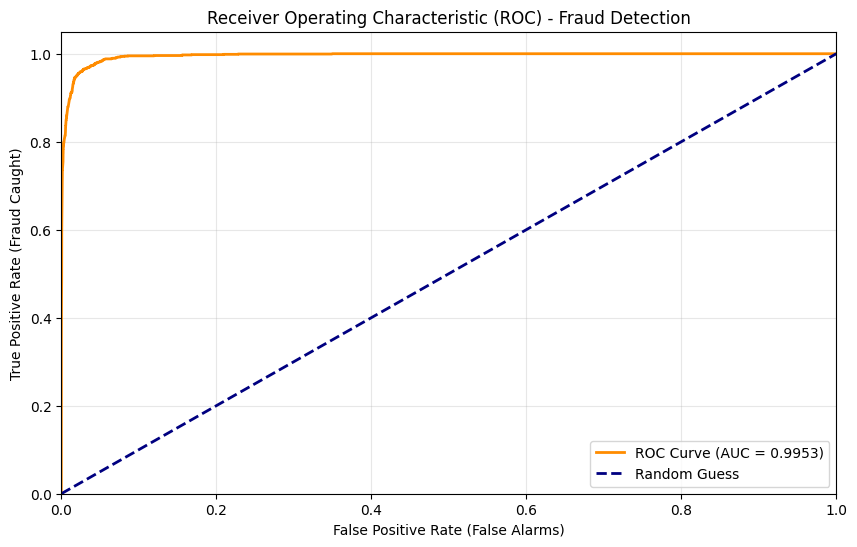

ROC AUC Score: 0.9953


In [0]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, auc
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType

def plot_roc_curve(predictions_df):
    print("--- Generating ROC Curve ---")
    
    # 1. Extract Probability of Fraud (Class 1)
    # The 'probability' column is a vector [Prob_Normal, Prob_Fraud]. We need index 1.
    get_prob_udf = udf(lambda v: float(v[1]), FloatType())
    
    # Select only the columns we need (to make it fast)
    # We use the 'preds' dataframe from your training step
    data = predictions_df.select(
        col("is_fraud").alias("y_true"), 
        get_prob_udf(col("probability")).alias("y_score")
    )
    
    # 2. Convert to Pandas (Bring data to the driver for plotting)
    # The dataset is massive (>10M rows) so, add .sample(fraction=0.1, seed=42) before .toPandas()
    print("Converting to Pandas for plotting...")
    y_test = data.toPandas()
    
    # 3. Calculate FPR, TPR, and AUC
    fpr, tpr, thresholds = roc_curve(y_test['y_true'], y_test['y_score'])
    roc_auc = auc(fpr, tpr)
    
    # 4. Plot
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (False Alarms)')
    plt.ylabel('True Positive Rate (Fraud Caught)')
    plt.title('Receiver Operating Characteristic (ROC) - Fraud Detection')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    
    # Show the plot
    plt.show()
    print(f"ROC AUC Score: {roc_auc:.4f}")

# --- EXECUTE ---
# Ensure you pass the 'preds' variable from your training function
plot_roc_curve(preds)

--- Extracting Feature Importance ---


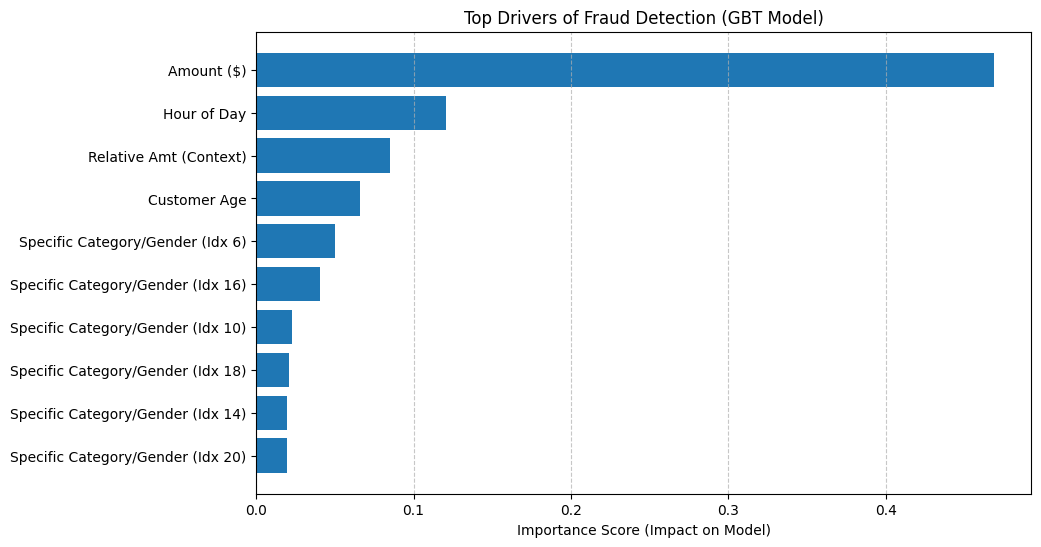

Interpretation:
The top feature is 'Amount ($)'. This is the strongest signal for fraud.


In [0]:
import pandas as pd
import matplotlib.pyplot as plt

def visualize_feature_importance(model):
    print("--- Extracting Feature Importance ---")
    
    # 1. Get the GBT model from the end of the Pipeline
    gbt_model = model.stages[-1]
    importances = gbt_model.featureImportances
    
    # 2. Map the indices to readable names
    # This matches the order in your 'VectorAssembler'
    feature_map = {
        0: "Amount ($)",
        1: "Relative Amt (Context)",
        2: "Hour of Day",
        3: "Day of Week",
        4: "Customer Age",
        5: "Distance (km)"
    }
    
    # 3. Process the data
    data = []
    for index, score in zip(importances.indices, importances.values):
        # If index is 0-5, use the name. If >5, it's part of the Category/Gender vectors
        name = feature_map.get(index, f"Specific Category/Gender (Idx {index})")
        data.append({"Feature": name, "Importance": score})
        
    # 4. Create a DataFrame & Sort
    pdf = pd.DataFrame(data).sort_values("Importance", ascending=False).head(10)
    
    # 5. Plot nicely
    plt.figure(figsize=(10, 6))
    # Create horizontal bar chart
    plt.barh(pdf["Feature"], pdf["Importance"], color='#1f77b4')
    
    plt.xlabel("Importance Score (Impact on Model)")
    plt.title("Top Drivers of Fraud Detection (GBT Model)")
    plt.gca().invert_yaxis() # Put the biggest bar at the top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Show the plot
    plt.show()
    
    print("Interpretation:")
    print(f"The top feature is '{pdf.iloc[0]['Feature']}'. This is the strongest signal for fraud.")

# --- EXECUTE ---
# Pass the 'model' variable from your training step
visualize_feature_importance(model)

--- Generating Final Business Dashboard Data ---
Saving to project_fraud_detection.gold_layer.fraud_predictions...
Success! Dashboard table is ready.
--- Top Blocked Transactions ---


actual_label,prediction,fraud_probability,amount,category,hour_of_day,amt_relative_to_category,action_recommendation,prediction_time
1,1.0,0.9882266,8.93,gas_transport,1,0.1407749708893028,BLOCK_TRANSACTION,2026-01-30T07:38:41.525Z
1,1.0,0.9882266,8.99,gas_transport,2,0.14172082735664415,BLOCK_TRANSACTION,2026-01-30T07:38:41.525Z
1,1.0,0.9882266,9.08,gas_transport,3,0.14313961205765616,BLOCK_TRANSACTION,2026-01-30T07:38:41.525Z
1,1.0,0.9882266,9.18,gas_transport,2,0.14471603950322506,BLOCK_TRANSACTION,2026-01-30T07:38:41.525Z
1,1.0,0.9882266,9.25,gas_transport,3,0.1458195387151233,BLOCK_TRANSACTION,2026-01-30T07:38:41.525Z
1,1.0,0.9882266,9.33,gas_transport,3,0.14708068067157842,BLOCK_TRANSACTION,2026-01-30T07:38:41.525Z
1,1.0,0.9882266,9.56,gas_transport,3,0.15070646379638689,BLOCK_TRANSACTION,2026-01-30T07:38:41.525Z
1,1.0,0.9882266,9.94,gas_transport,1,0.1566968880895487,BLOCK_TRANSACTION,2026-01-30T07:38:41.525Z
1,1.0,0.9882266,10.3,gas_transport,2,0.16237202689359675,BLOCK_TRANSACTION,2026-01-30T07:38:41.525Z
1,1.0,0.9882266,10.64,gas_transport,0,0.16773188020853103,BLOCK_TRANSACTION,2026-01-30T07:38:41.525Z


--- Generating Business Dashboard Charts ---


/home/spark-4617bf84-ec45-44e2-a9ec-d8/.ipykernel/2573/command-4983026445301077-3827497560:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg_df, x='action_recommendation', y='total_money_saved_usd', palette=palette, ax=axes[0])
/home/spark-4617bf84-ec45-44e2-a9ec-d8/.ipykernel/2573/command-4983026445301077-3827497560:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_ops, x='action_recommendation', y='transactions_flagged', palette=palette, ax=axes[1])
/home/spark-4617bf84-ec45-44e2-a9ec-d8/.ipykernel/2573/command-4983026445301077-3827497560:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable t

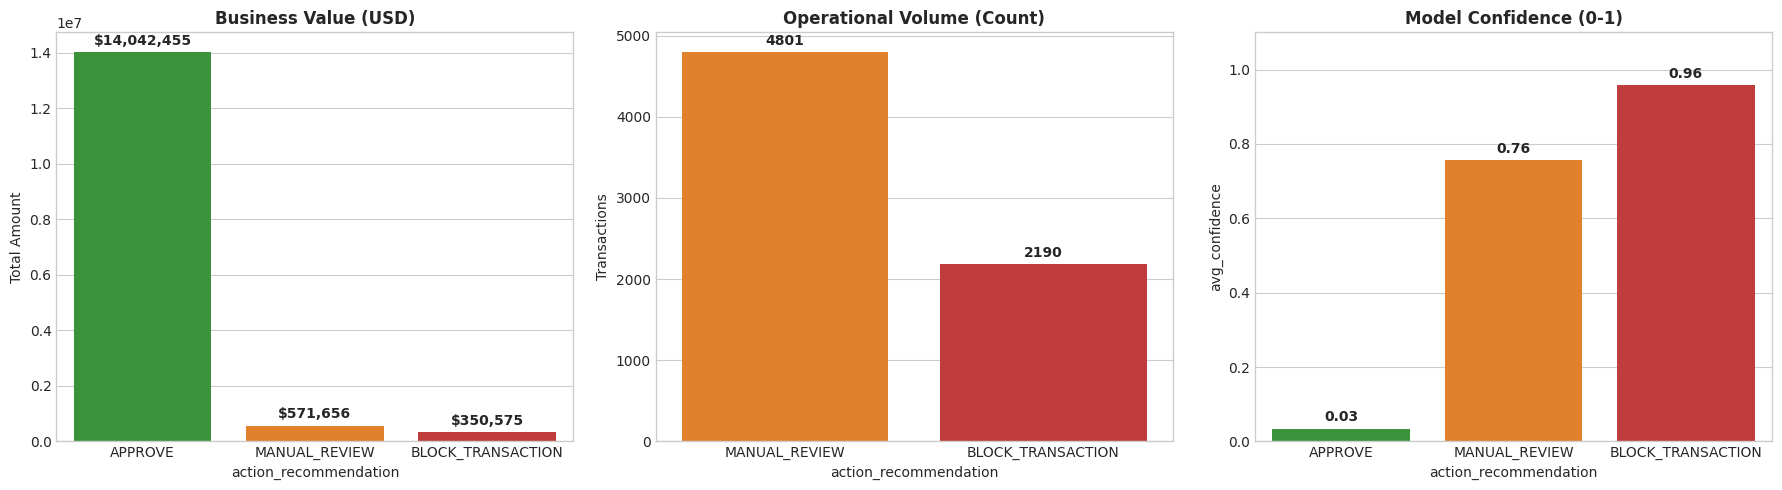

In [0]:
from pyspark.sql.functions import col, when, udf, desc, current_timestamp, sum, avg, count
from pyspark.sql.types import FloatType
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
CATALOG = "project_fraud_detection"
PRED_TABLE = f"{CATALOG}.gold_layer.fraud_predictions"

# UDF to extract probability index 1 (Fraud Score)
get_fraud_prob = udf(lambda v: float(v[1]), FloatType())

def generate_final_dashboard_data(model, predictions_df):
    print("--- Generating Final Business Dashboard Data ---")
    
    # 1. Extract the numeric score
    final_preds = predictions_df.withColumn("fraud_probability", get_fraud_prob(col("probability")))

    # 2. APPLY THE "MONEY SAVING" RULES
    final_output = final_preds.select(
        col("is_fraud").alias("actual_label"),
        col("prediction"),
        col("fraud_probability"),
        col("amount"),
        col("category"),
        col("hour_of_day"),
        col("amt_relative_to_category"),
        
        # The Actionable Insight
        when(col("fraud_probability") > 0.90, "BLOCK_TRANSACTION")
        .when(col("fraud_probability") > 0.50, "MANUAL_REVIEW")
        .otherwise("APPROVE").alias("action_recommendation"),
        
        current_timestamp().alias("prediction_time")
    )

    # 3. Save to Table for SQL Dashboarding
    print(f"Saving to {PRED_TABLE}...")
    (final_output.write
        .format("delta")
        .mode("overwrite")
        .option("overwriteSchema", "true")
        .saveAsTable(PRED_TABLE))
        
    print("Success! Dashboard table is ready.")
    
    # 4. Display Detailed Table (First Output)
    print("--- Top Blocked Transactions ---")
    display(final_output.filter(col("action_recommendation") == "BLOCK_TRANSACTION")
            .orderBy(desc("fraud_probability")))

    # --- ADDED: AUTOMATIC VISUALIZATION CODE ---
    print("--- Generating Business Dashboard Charts ---")
    
    # A. Aggregate Data for Plotting (Spark -> Pandas)
    agg_df = final_output.groupBy("action_recommendation").agg(
        sum("amount").alias("total_money_saved_usd"),
        count("*").alias("transactions_flagged"),
        avg("fraud_probability").alias("avg_confidence")
    ).toPandas()
    
    # Sort for consistent charting
    agg_df = agg_df.sort_values(by="total_money_saved_usd", ascending=False)
    
    # B. Plotting
    plt.style.use('seaborn-v0_8-whitegrid')
    palette = {"BLOCK_TRANSACTION": "#d62728", "MANUAL_REVIEW": "#ff7f0e", "APPROVE": "#2ca02c"}
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Chart 1: Money Saved
    sns.barplot(data=agg_df, x='action_recommendation', y='total_money_saved_usd', palette=palette, ax=axes[0])
    axes[0].set_title('Business Value (USD)', fontweight='bold')
    axes[0].set_ylabel('Total Amount')
    for container in axes[0].containers:
        labels = [f'${val:,.0f}' for val in container.datavalues]
        axes[0].bar_label(container, labels=labels, padding=3, fontweight='bold')

    # Chart 2: Volume
    df_ops = agg_df[agg_df['action_recommendation'] != 'APPROVE'] # Focus on interventions
    sns.barplot(data=df_ops, x='action_recommendation', y='transactions_flagged', palette=palette, ax=axes[1])
    axes[1].set_title('Operational Volume (Count)', fontweight='bold')
    axes[1].set_ylabel('Transactions')
    for container in axes[1].containers:
        axes[1].bar_label(container, fmt='%.0f', padding=3, fontweight='bold')

    # Chart 3: Confidence
    sns.barplot(data=agg_df, x='action_recommendation', y='avg_confidence', palette=palette, ax=axes[2])
    axes[2].set_title('Model Confidence (0-1)', fontweight='bold')
    axes[2].set_ylim(0, 1.1)
    for container in axes[2].containers:
        axes[2].bar_label(container, fmt='%.2f', padding=3, fontweight='bold')

    plt.tight_layout()
    plt.show()

# --- EXECUTE ---
generate_final_dashboard_data(model, preds)

--- Final Business Impact Report ---


action_recommendation,transactions_flagged,avg_confidence_percent,total_money_saved_usd
APPROVE,252006,3.5,1.404245455E7
MANUAL_REVIEW,4801,75.6,571656.18
BLOCK_TRANSACTION,2190,95.7,350575.18


--- Visualizing Results ---


/home/spark-4617bf84-ec45-44e2-a9ec-d8/.ipykernel/2573/command-4983026445301079-2759371695:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_dashboard, x='action_recommendation', y='total_money_saved_usd', palette=palette)


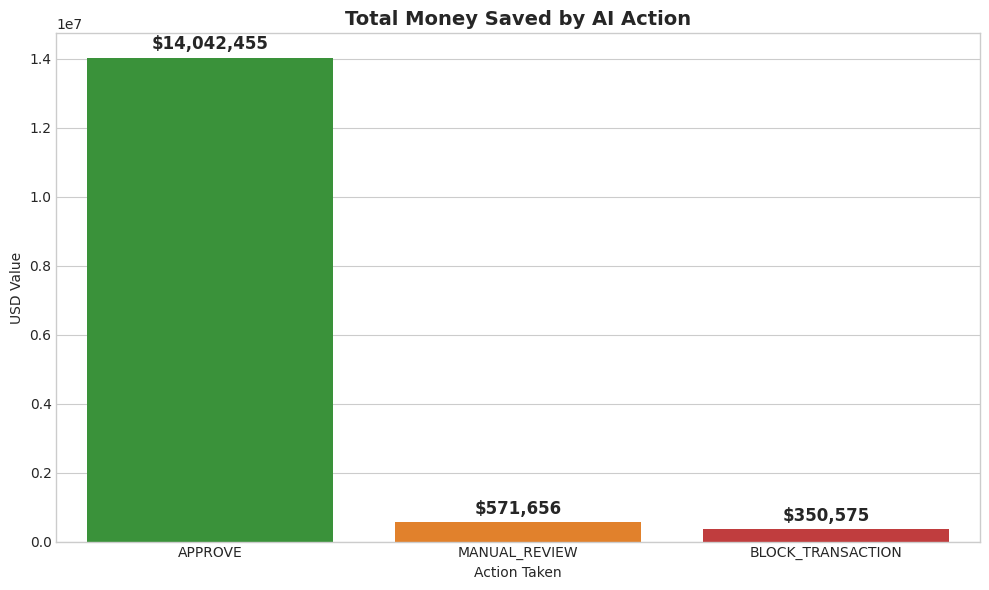

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. EXECUTE SQL QUERY (The Table)
query = """
SELECT 
  action_recommendation,
  COUNT(*) as transactions_flagged,
  ROUND(AVG(fraud_probability) * 100, 1) as avg_confidence_percent,
  ROUND(SUM(amount), 2) as total_money_saved_usd
FROM project_fraud_detection.gold_layer.fraud_predictions
WHERE action_recommendation IN ('BLOCK_TRANSACTION', 'MANUAL_REVIEW', 'APPROVE')
GROUP BY action_recommendation
ORDER BY total_money_saved_usd DESC
"""

# Run query and convert to Pandas for plotting
df_dashboard = spark.sql(query).toPandas()

# DISPLAY TABLE (First Output)
print("--- Final Business Impact Report ---")
display(spark.createDataFrame(df_dashboard)) # Uses Databricks display for nice table

# 2. GENERATE VISUALIZATION (Second Output)
print("--- Visualizing Results ---")
plt.style.use('seaborn-v0_8-whitegrid')
palette = {"BLOCK_TRANSACTION": "#d62728", "MANUAL_REVIEW": "#ff7f0e", "APPROVE": "#2ca02c"}

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_dashboard, x='action_recommendation', y='total_money_saved_usd', palette=palette)

# Add Labels
for container in ax.containers:
    labels = [f'${val:,.0f}' for val in container.datavalues]
    ax.bar_label(container, labels=labels, padding=3, fontsize=12, fontweight='bold')

plt.title('Total Money Saved by AI Action', fontsize=14, fontweight='bold')
plt.xlabel('Action Taken')
plt.ylabel('USD Value')
plt.tight_layout()
plt.show()